## Document Image Classification Using Machine Learning Neural Networks
                                                                          -- Nixon Varghese

 * This Prototype Neural Network is trained using a very small data set of 471 images to identify 5 different Classes of Document Images listed below. For the purpose of the experiment this model leverages a pre-trained Neural Network, orginally trained to identify 1000 different classs. 
   - 1 - Screen Shot
   - 2 - Photograph
   - 3 - Handwritten
   - 4 - Code
   - 5 - Documents
 * This is the same technology used to Detect Vehicles/Objects in Self Driving Cars/Videos/Images
 * Possibility to integrate with Vontu image detection policies via the Symantec Network Monitor API/Any data source which provides access to the image file
 * Orginally, based on a research paper  http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf by Yann LeCun, Director of AI Research, Facebook 

In [1]:
import numpy as np
import pickle

#Load the data from pickle file
data_pickle = pickle.load(open( "./pickle_data/data_pickle.p", "rb" ))
X_train = data_pickle["train"]
y_train = data_pickle["label"]

### Size of the data set

In [2]:
print(X_train.shape, y_train.shape)

(704, 227, 227, 3) (704,)


### Randomly Plot Images from the Training Data Set

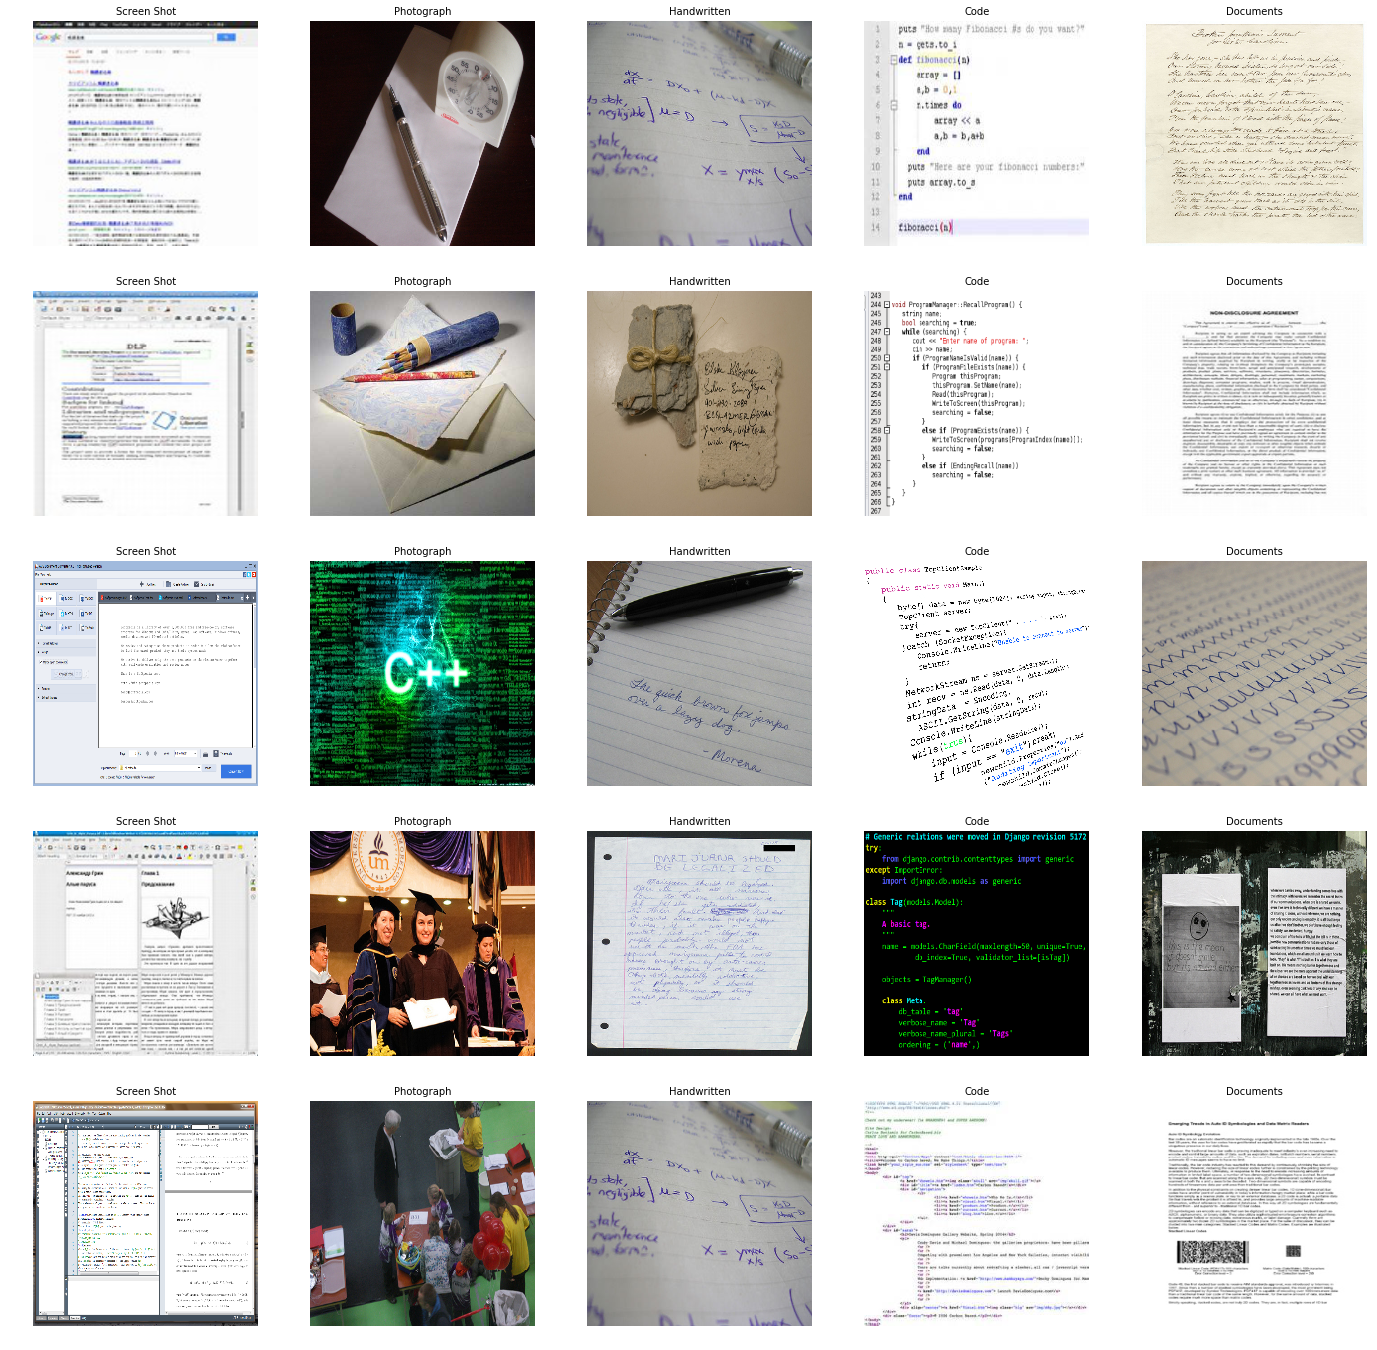

In [5]:
fig, axes = plt.subplots(5,5, figsize = (24, 24))
plt.axis('off')
for i in range(25):
    #print(np.where(y_train==(i%43))[0])
    index = np.random.choice(np.where(y_train==(i%5))[0])
    #index = np.random.choice(indices_of_label[i%43])
    axes.flat[i].imshow(X_train[index])
    axes.flat[i].set_title(sign_names[i%5], fontsize = 10)
    axes.flat[i].axis('off')

### Data exploration and visualization

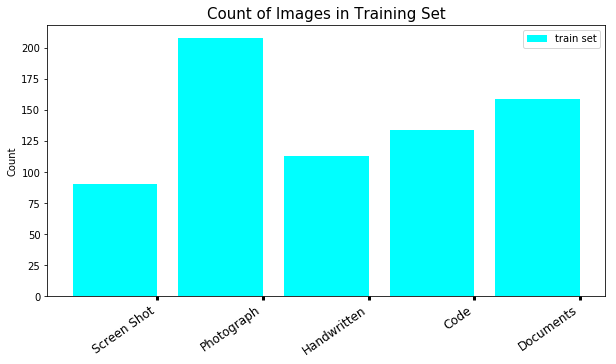

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Visualizations will be shown in the notebook.
%matplotlib inline

# Example data
sign, counts = np.unique(y_train, return_counts = True)
#test_sign, test_counts = np.unique(y_test, return_counts = True)
sign_values = np.genfromtxt('signnames.txt',  dtype='U', delimiter=',' , skip_header =1)
#print(sign.shape)
sign_names = sign_values[:,1]
#print(len(sign), len(counts))


fig, ax = plt.subplots(figsize = (10, 5))
plt.bar(sign, counts, color = 'cyan', label = 'train set')
#plt.bar(test_sign, test_counts, color = 'g', label = 'test_set')
plt.xticks(np.arange(5) + 0.4 , sign_names, rotation='35', fontsize = 12, ha = 'right')
#plt.xticks(np.arange(43) + 0.4 , [sign_name[i] for i in range(43)], rotation='35', fontsize = 12, ha = 'right')
ax.xaxis.set_tick_params(width=3)
ax.set_title('Count of Images in Training Set', fontsize = 15)
#ax.set_yticks(y_pos)
ax.set_ylabel('Count')
#ax.invert_yaxis()  # labels read top-to-bottom
plt.legend();
plt.show()

### Normalize the Data

In [6]:
import numpy as np

def image_normalize(X_train, y_train):
    """Apply preprocessing to make every pixel value to range between 0-1"""

    new = X_train[0:2]
    newy = y_train[0:2]
    for offset in range(0, len(X_train), 500):
        batch_x, batch_y = (X_train[offset:offset+500]-128.0)/128.0, y_train[offset:offset+500]
        #batch_x, batch_y = X_train[offset:offset+500]/255.0, y_train[offset:offset+500]
        new = np.append(new, batch_x, axis=0)
        newy = np.append(newy, batch_y, axis=0)
        #total_accuracy += (accuracy * len(batch_x))
    #print(new.shape, newy.shape)
    X_train, y_train = new[2:], newy[2:]
    #print(X_train.shape, y_train.shape)
    return X_train, y_train

In [7]:
X_train, y_train= image_normalize(X_train, y_train)

In [8]:
print(X_train.shape, y_train.shape)

(704, 227, 227, 3) (704,)


#### Split Training and Validation set

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(471, 227, 227, 3) (471,)
(233, 227, 227, 3) (233,)


## Train the Machine Learning Neural Network Model - using pretrained weights from ImageNet

In [12]:
import pickle
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from docClassify import Doc_Classify_NN

nb_classes = 5
epochs = 30
batch_size = 128
#keep_prob = 0.2

features = tf.placeholder(tf.float32, (None, 227, 227, 3))
labels = tf.placeholder(tf.int64, None)

# this allows us to redo the last layer for the specifically for 
# the document classification model.
fc7 = Doc_Classify_NN(features, feature_extract=True)
fc7 = tf.stop_gradient(fc7)
shape = (fc7.get_shape().as_list()[-1], nb_classes)
fc8W = tf.Variable(tf.truncated_normal(shape, stddev=1e-2))
fc8b = tf.Variable(tf.zeros(nb_classes))
logits = tf.nn.xw_plus_b(fc7, fc8W, fc8b)
probs = tf.nn.softmax(logits)


cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
loss_op = tf.reduce_mean(cross_entropy)
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op, var_list=[fc8W, fc8b])
init_op = tf.global_variables_initializer()

preds = tf.arg_max(logits, 1)
accuracy_op = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))


def eval_on_data(X, y, sess):
    total_acc = 0
    total_loss = 0
    for offset in range(0, X.shape[0], batch_size):
        end = offset + batch_size
        X_batch = X[offset:end]
        y_batch = y[offset:end]

        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={features: X_batch, labels: y_batch})
        total_loss += (loss * X_batch.shape[0])
        total_acc += (acc * X_batch.shape[0])

    return total_loss/X.shape[0], total_acc/X.shape[0]

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init_op)

    for i in range(epochs):
        # training
        X_train, y_train = shuffle(X_train, y_train)
        t0 = time.time()
        for offset in range(0, X_train.shape[0], batch_size):
            end = offset + batch_size
            sess.run(train_op, feed_dict={features: X_train[offset:end], labels: y_train[offset:end]})

        val_loss, val_acc = eval_on_data(X_val, y_val, sess)
        print("Epoch", i+1)
        print("Time: %.3f seconds" % (time.time() - t0))
        print("Validation Loss =", val_loss)
        print("Validation Accuracy =", val_acc)
        print("")
        
    saver.save(sess, './testModel')
    print("Model saved")

Epoch 1
Time: 6.688 seconds
Validation Loss = 1.30882042109
Validation Accuracy = 0.467811198449

Epoch 2
Time: 2.353 seconds
Validation Loss = 1.04425108586
Validation Accuracy = 0.609442095388

Epoch 3
Time: 2.357 seconds
Validation Loss = 0.952984524387
Validation Accuracy = 0.6094420959

Epoch 4
Time: 2.351 seconds
Validation Loss = 0.878547838573
Validation Accuracy = 0.665236059432

Epoch 5
Time: 2.353 seconds
Validation Loss = 0.832498142136
Validation Accuracy = 0.699570848451

Epoch 6
Time: 2.351 seconds
Validation Loss = 0.799447842678
Validation Accuracy = 0.703862694456

Epoch 7
Time: 2.353 seconds
Validation Loss = 0.779714091653
Validation Accuracy = 0.712446384931

Epoch 8
Time: 2.353 seconds
Validation Loss = 0.765766133055
Validation Accuracy = 0.721030048802

Epoch 9
Time: 2.352 seconds
Validation Loss = 0.740596874589
Validation Accuracy = 0.721030048802

Epoch 10
Time: 2.350 seconds
Validation Loss = 0.731177657459
Validation Accuracy = 0.7253219209

Epoch 11
Time: 

### Test the Network on new set of test Images

In [13]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.image as mpimg

#Load the dat from pickle file
test_pickle = pickle.load(open( "./pickle_data/test_pickle.p", "rb" ))
X_test = test_pickle["train"]
y_test = test_pickle["label"]

In [14]:
print(X_test.shape, y_test.shape)

(77, 227, 227, 3) (77,)


In [15]:
#Pre-process new test image
new_X_test, new_y_test= image_normalize(X_test, y_test)

###  Evaluate the model for Test Accuracy

In [16]:

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver = tf.train.import_meta_graph('./testModel02.meta')
    #saver.restore(sess, "./testModel02")
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_loss, test_acc = eval_on_data(new_X_test, new_y_test, sess)

    #test_accuracy = eval_on_data(new_X_test, new_y_test, sess) #Change Keep Probablity to 1.0, No dropout required for prediction
    print("Test Accuracy = {:.3f}".format(test_acc))

Test Accuracy = 0.766


#### Test Accuracy - 76.6%, Can be improved when trained on large datasets and powerful Neural Network Architectures

### Calculate Top 5 Probability

In [17]:
softmax_score = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_score, k=5)

#get softmaxscore

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_score_value, top_k_predict = sess.run([softmax_score, top_k], feed_dict = {features: new_X_test})

### Visualize Top 5 Prediction

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


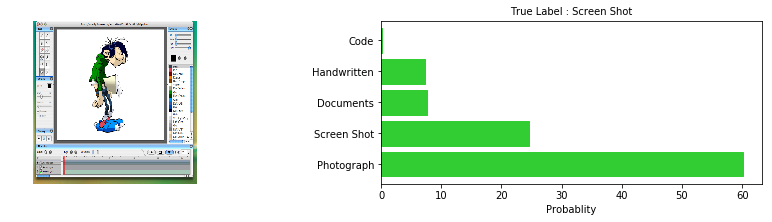

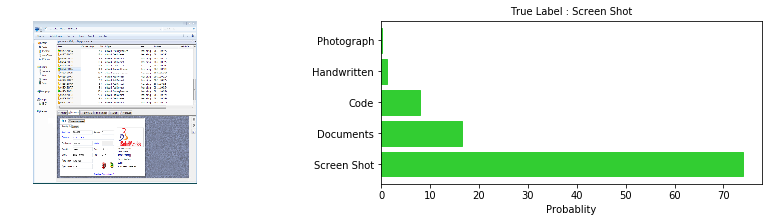

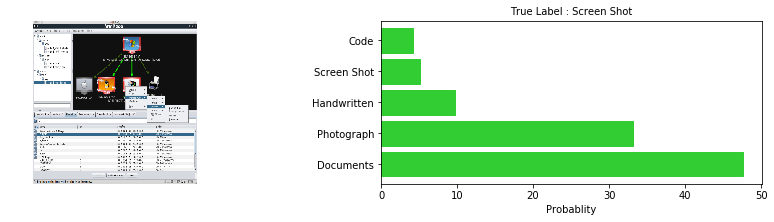

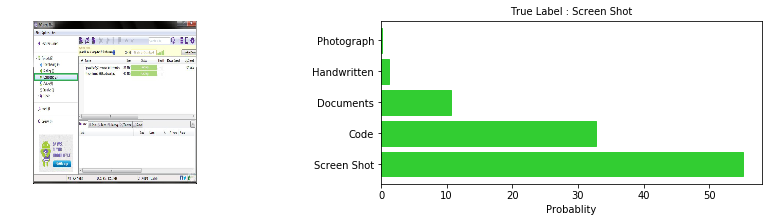

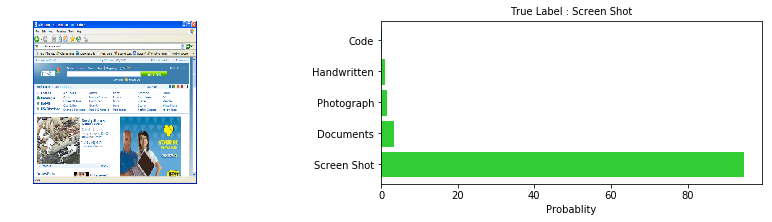

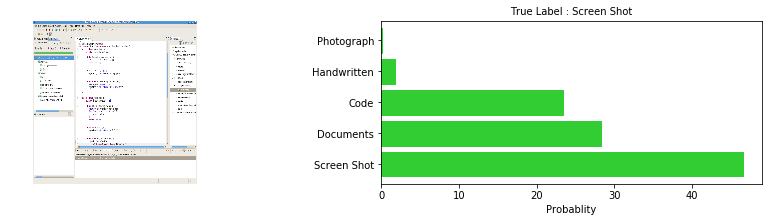

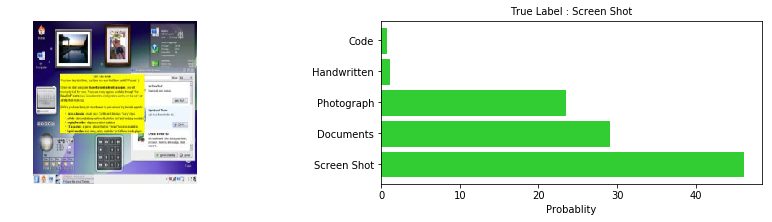

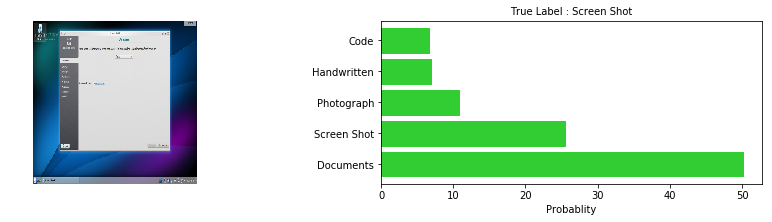

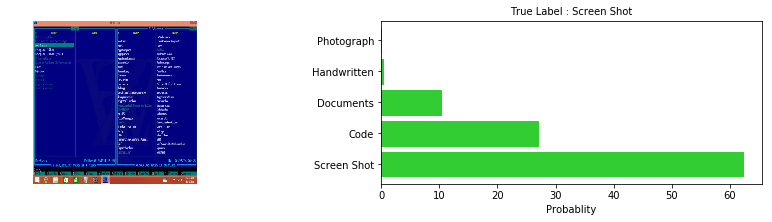

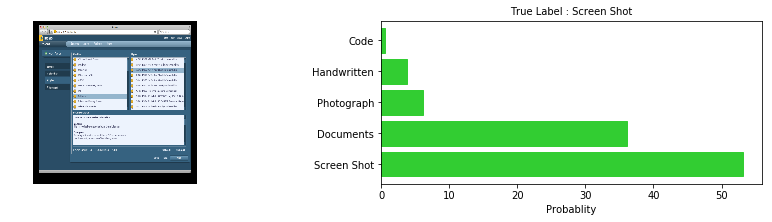

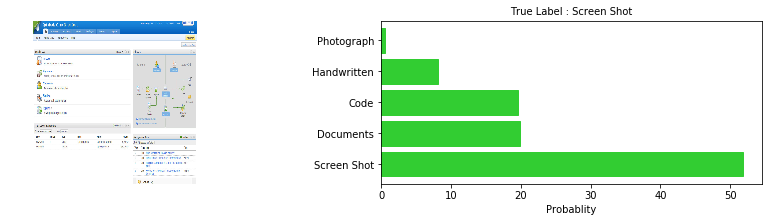

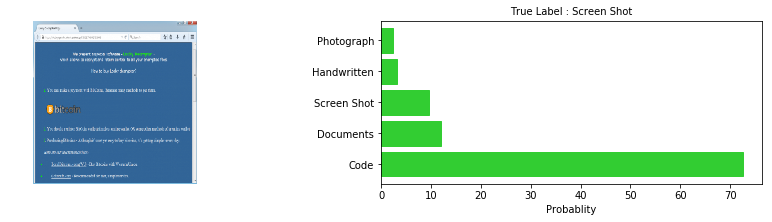

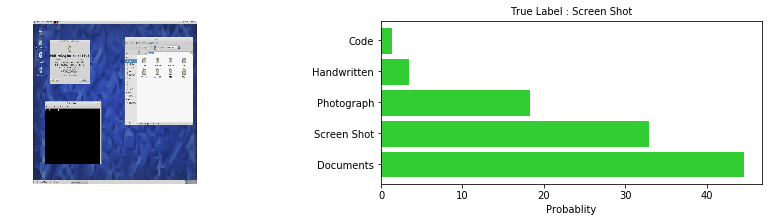

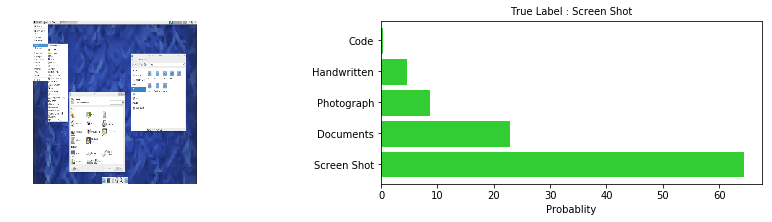

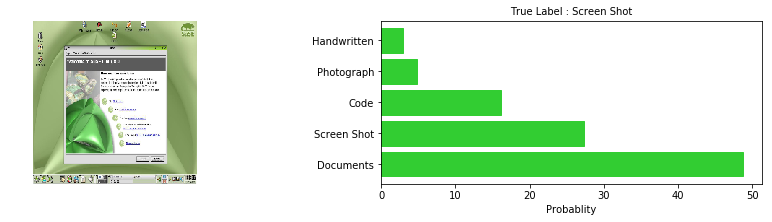

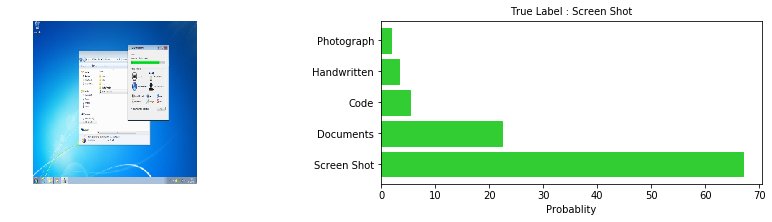

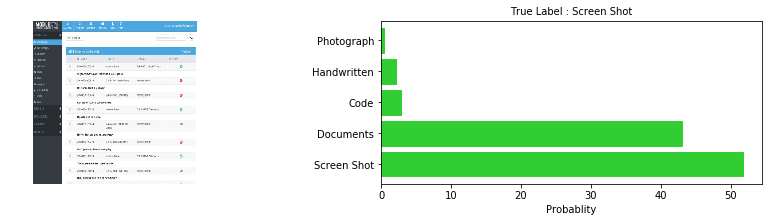

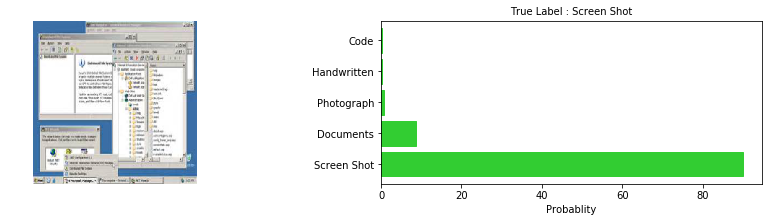

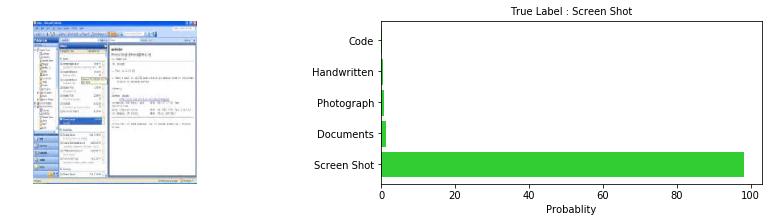

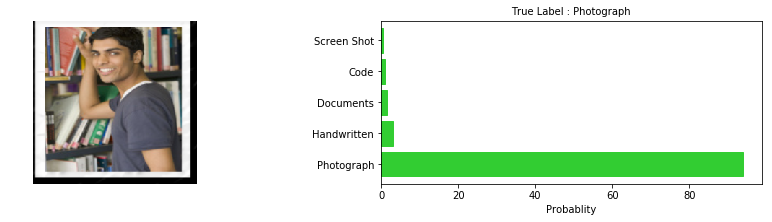

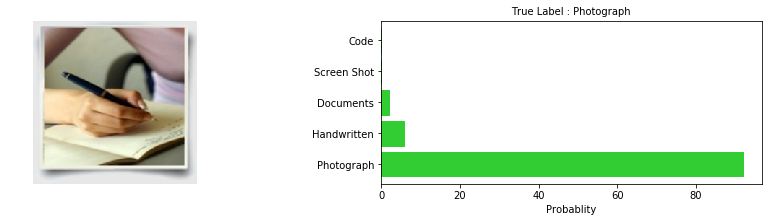

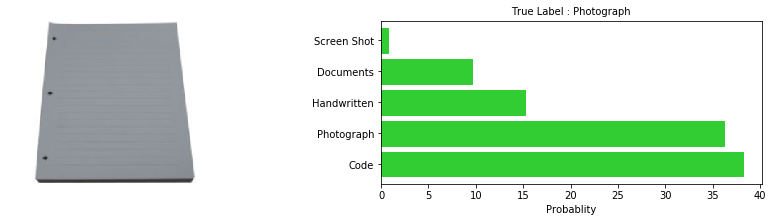

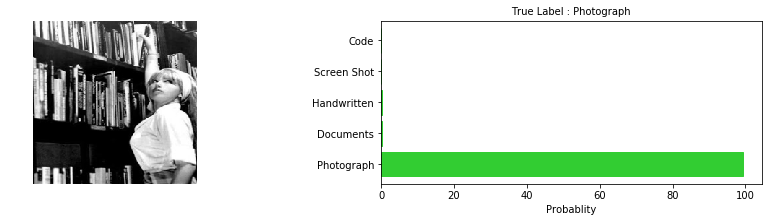

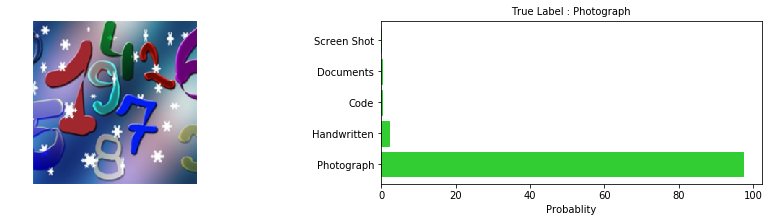

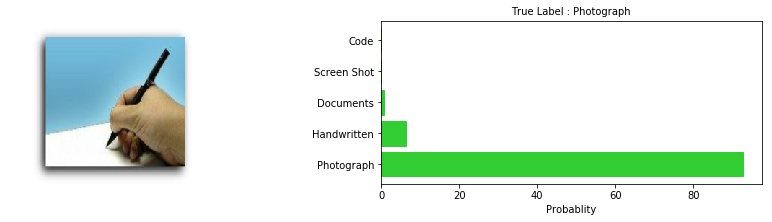

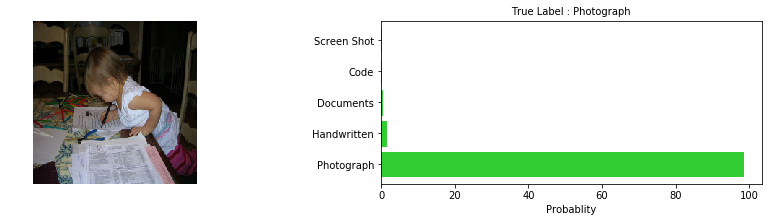

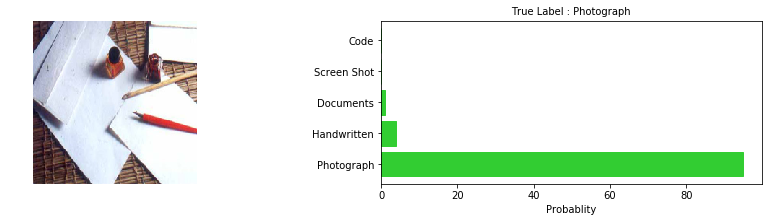

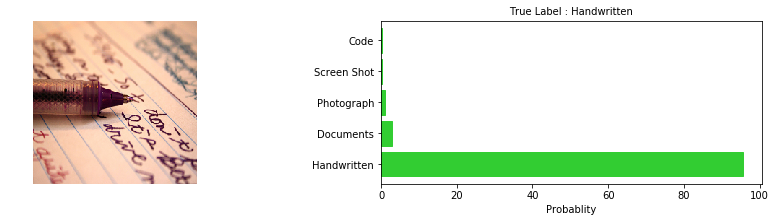

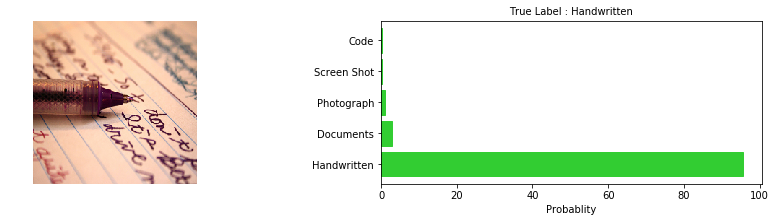

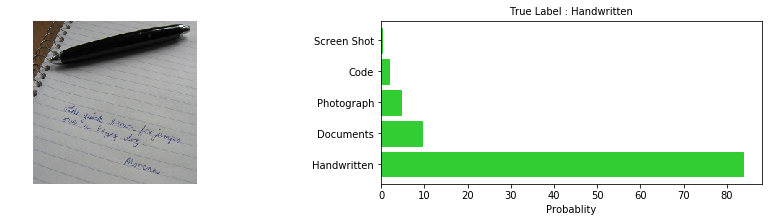

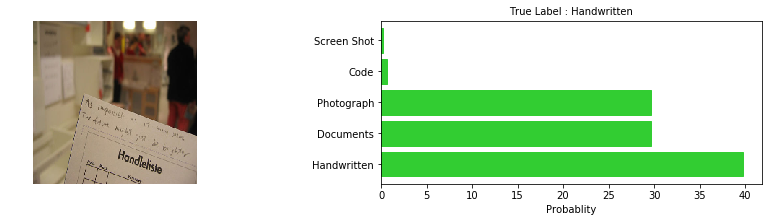

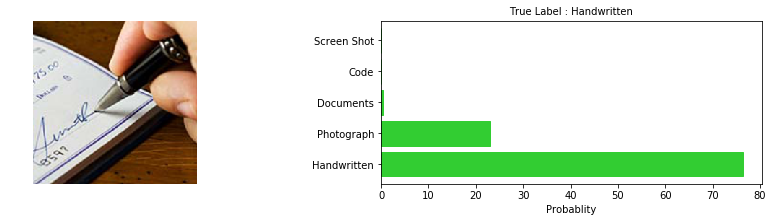

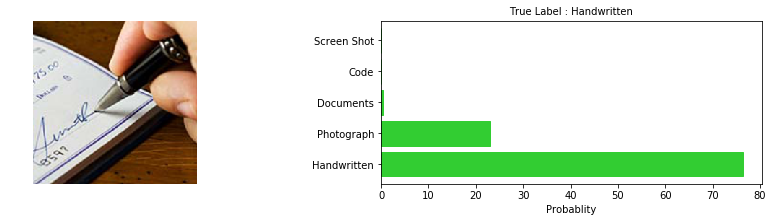

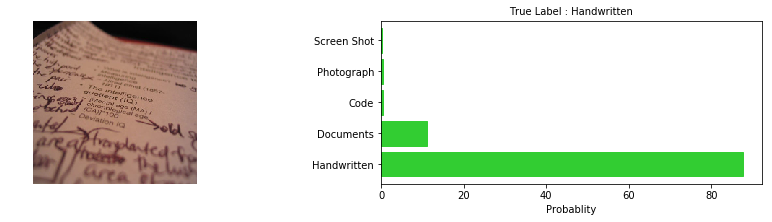

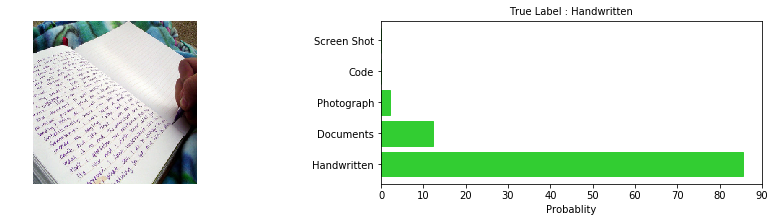

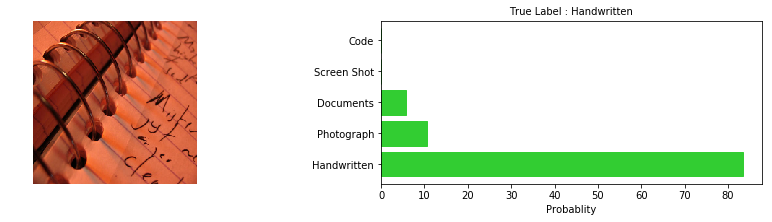

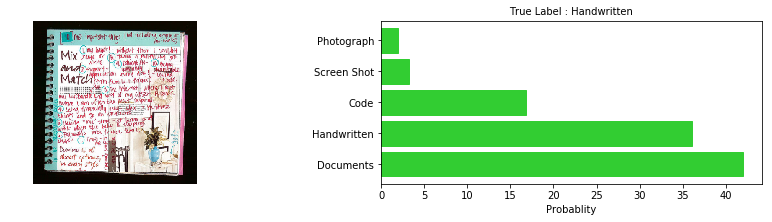

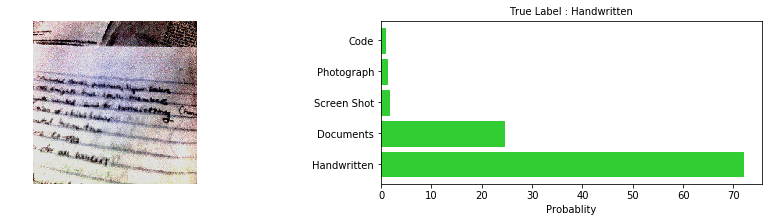

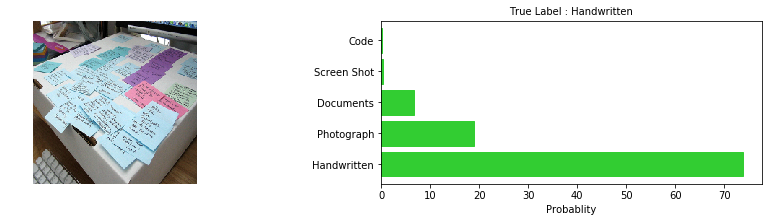

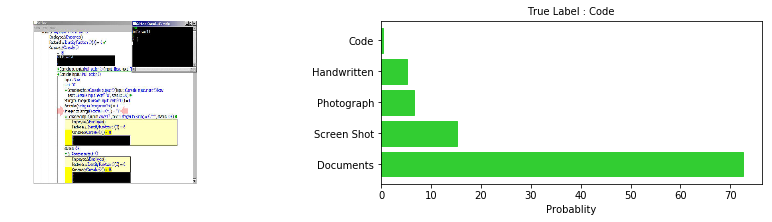

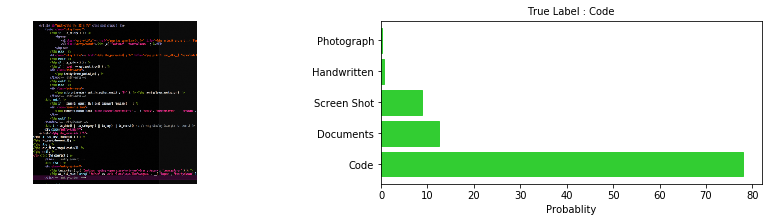

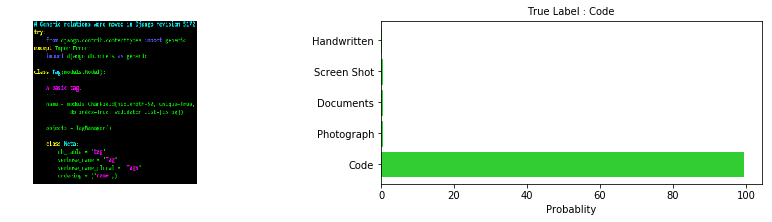

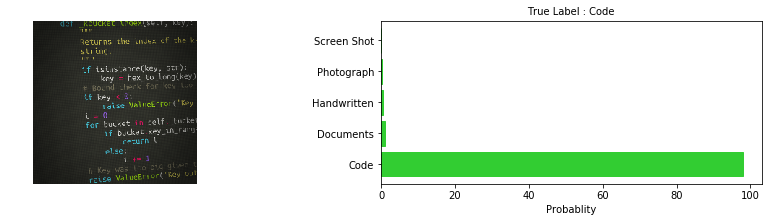

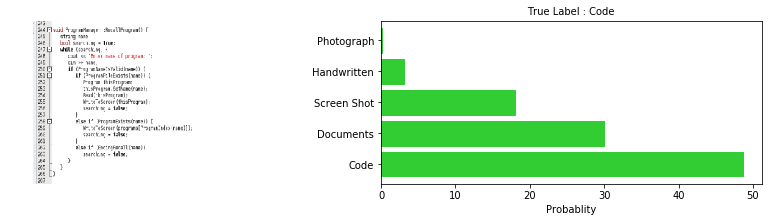

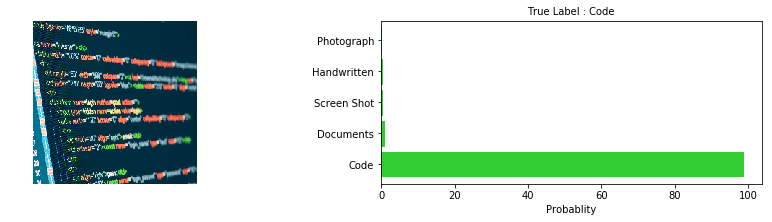

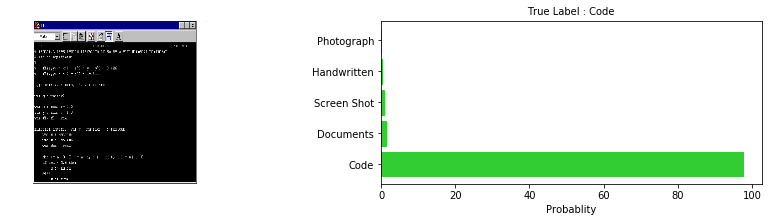

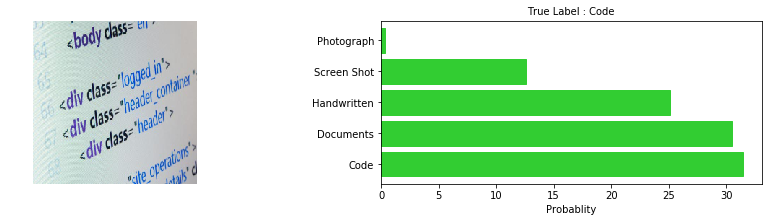

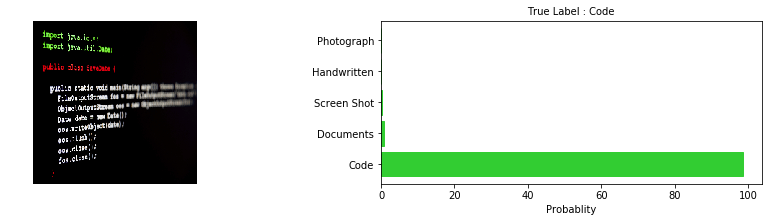

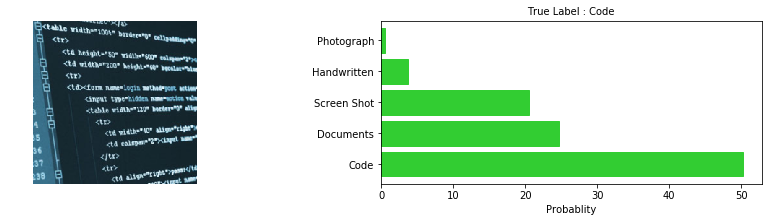

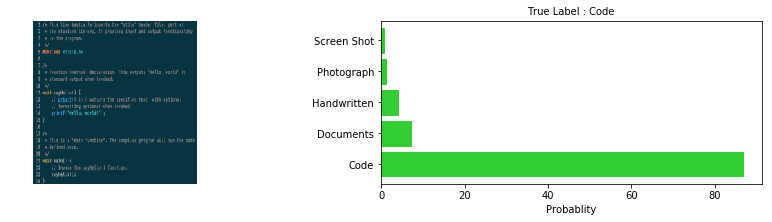

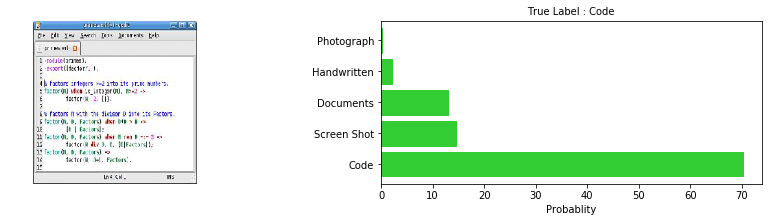

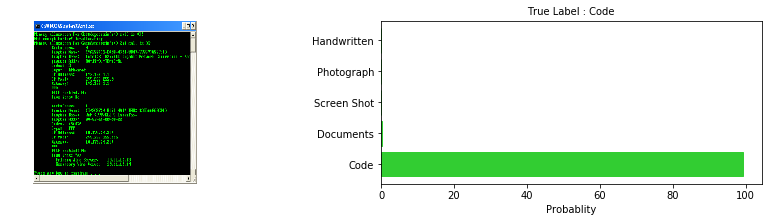

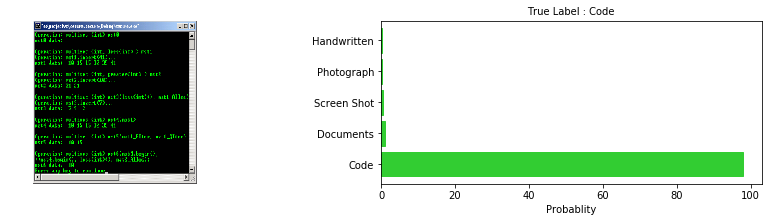

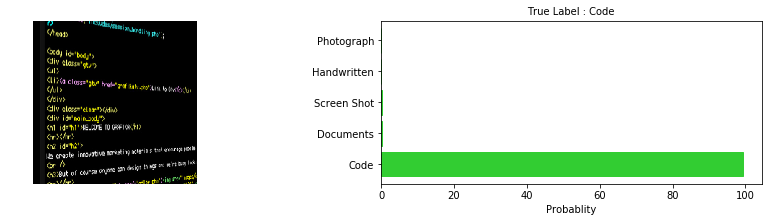

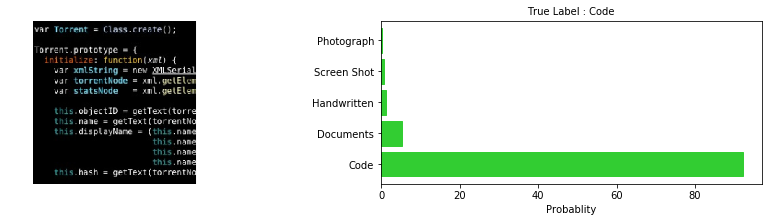

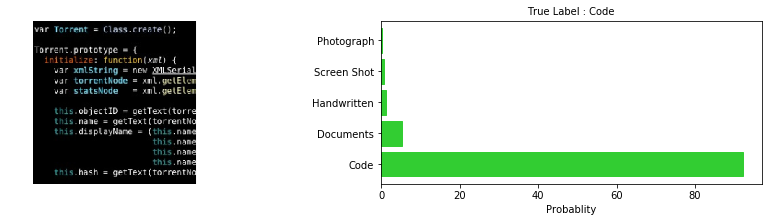

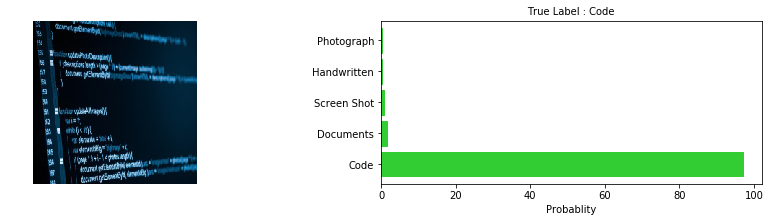

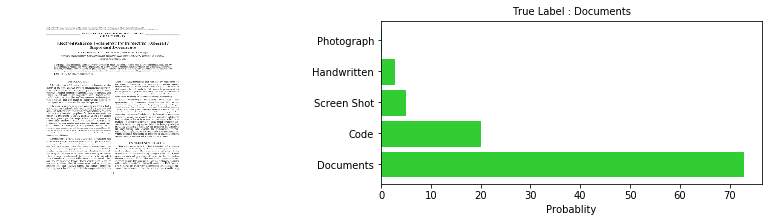

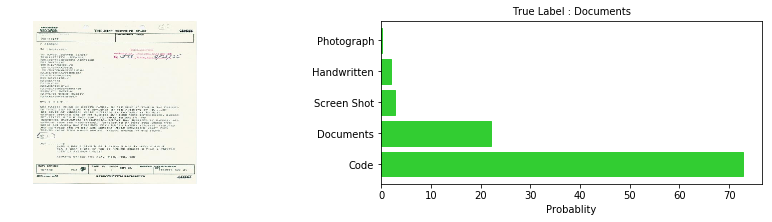

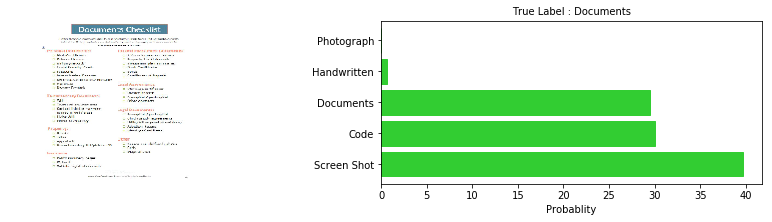

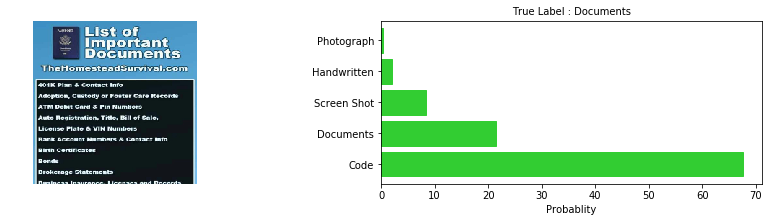

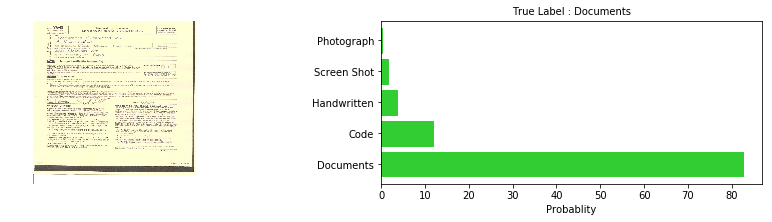

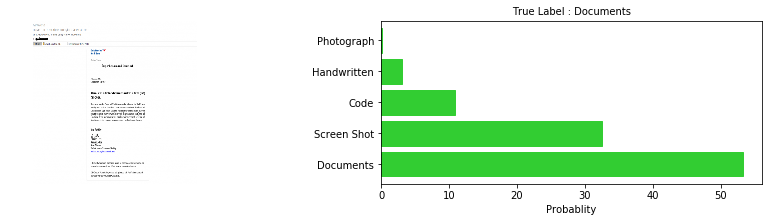

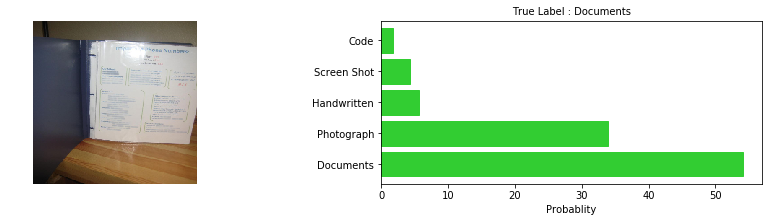

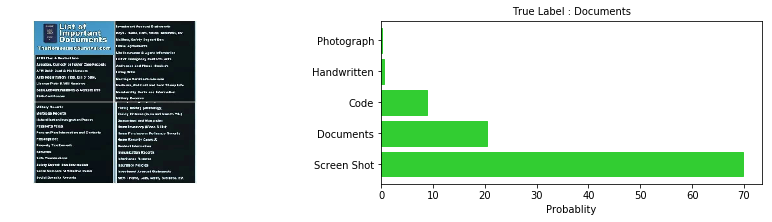

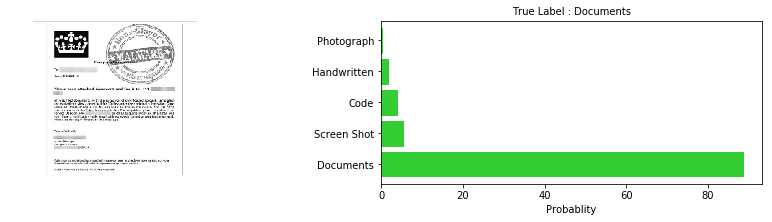

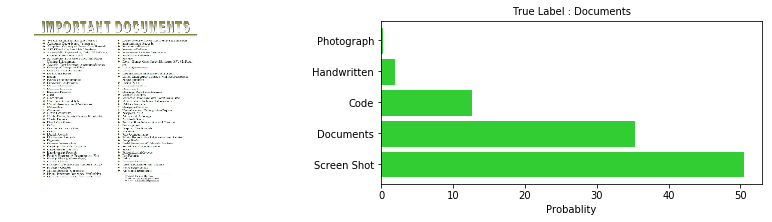

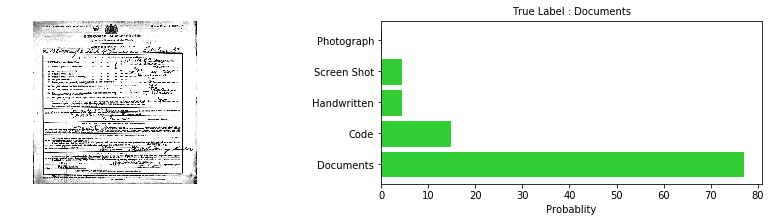

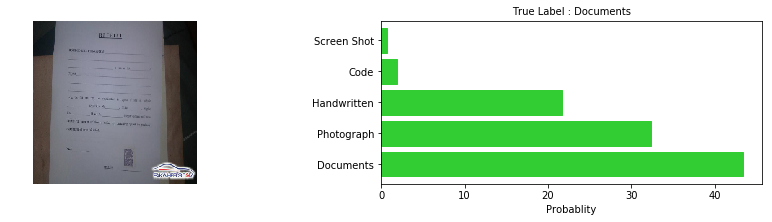

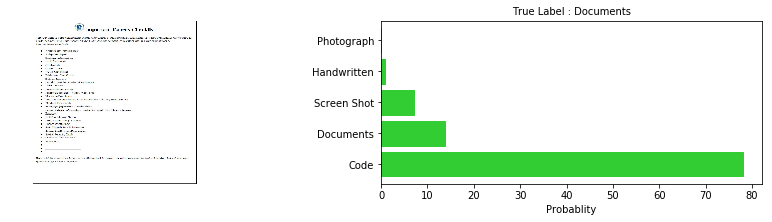

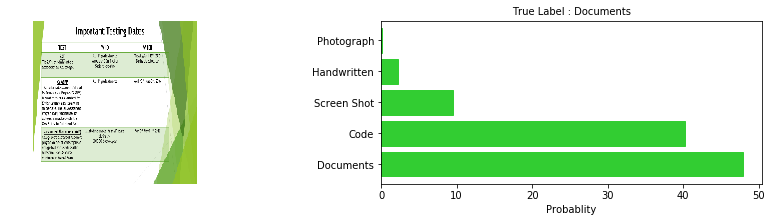

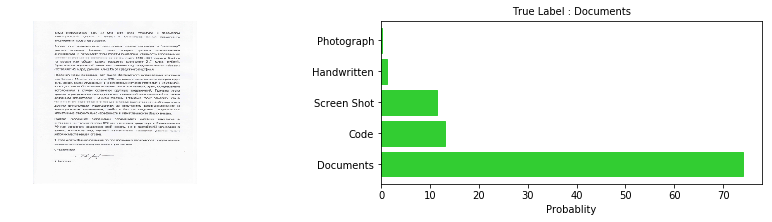

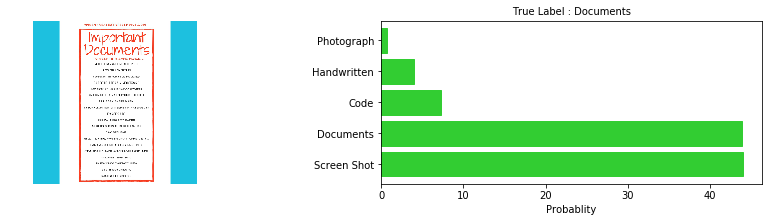

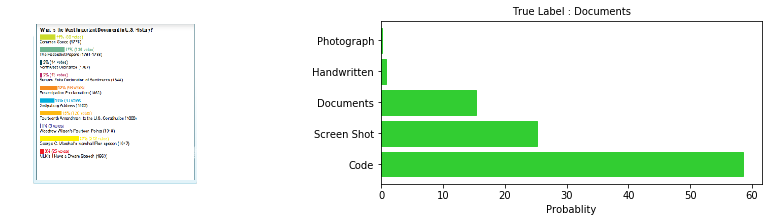

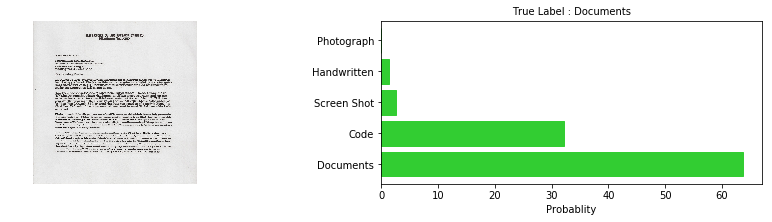

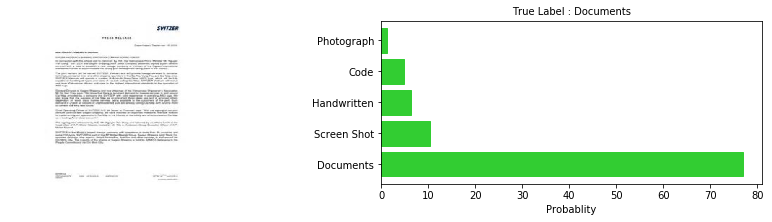

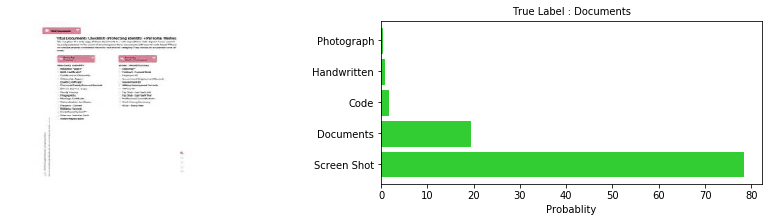

In [18]:
#Define X axis to 5 range
x = np.arange(1,6)

for i in range(len(y_test)):
    fig, ax = plt.subplots(1,2, figsize = (15, 3))
    ax[0].imshow(X_test[i].squeeze())
    ax[0].axis("off")
    ax[1].barh(x, top_k_predict[0][i]*100, height=0.8, color='limegreen', edgecolor='limegreen')
    plt.yticks(np.arange(1,6), sign_names[top_k_predict[1][i]], fontsize = 10, ha = 'right')
    ax[1].set_xlabel('Probablity')
    ax[1].set_title('True Label : '+str(sign_names[y_test[i]]), fontsize = 10)

#### This is just a prototype and the model can be improved, subject to the quality of the training set